# 1. Selekcja cech
## Usuwanie cech o niskiej wariancji
---
Usuwamy wszystkie cechy, których wariancja jest poniżej pewnego progu (domyślnie usuwane są cechy o wariancji równej 0).  
Dla zmiennych binarnych wariancja wyrażona jest wzorem: <b><i>Var[X] = p(p-1)</i></b>  
Przykład dla progu 0.8:

In [1]:
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt

X = [[0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 1, 1], [0, 1, 0], [0, 1, 1]]
sel = VarianceThreshold(threshold=(0.8 * (1 - 0.8)))
sel.fit_transform(X)

array([[0, 1],
       [1, 0],
       [0, 0],
       [1, 1],
       [1, 0],
       [1, 1]])

Jak widać usunięta została pierwsza cecha. Prawdopodobieństwo wystąpienia zera <b><i>p = 5/6</i></b> > 0.8  

## Sequential feature selection
---
### <span id="filterapproach">Filter approach</span>
W tym podejściu dla każdej cechy wyliczana jest odpowiednia wartość testu statystycznego, podanego jako parametr <code>score_func</code>, a następnie wybierane jest <i>k</i> cech, które uzyskały najwyższe wartości.  
Dostępne funkcje testujące:  
Dla regresji: <code>f_regression</code>, <code>mutual_info_regression</code>  
Dla klasyfikacji: <code>chi2</code>, <code>f_classif</code>, <code>mutual_info_classif</code>

Jako przykład wykorzystamy dane ze zbioru UCI: <a href="https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29"><b>Breast Cancer Wisconsin (Diagnostic) Data Set</b></a>, dotyczące klasyfikacji raka piersi jako złośliwego bądź łagodnego, na podstawie pomiarów jąder komórkowych uzyskanych ze zdjęć pobranej masy.  

Dla każdego przypadku oprócz identyfikatora pacjenta oraz diagnozy podane są zmierzone wartości dotyczące jąder komórkowych. Mierzonych cech jest 10, natomiast dla każdej z nich podana jest najpierw wartość średnia, następnie wartość błędu standardowego, a na koniec najgorsza ze zmierzonych wartości, co daje w sumie 30 cech.  

Wszystkich przypadków jest 569


In [2]:
# wczytanie danych

import pandas as pd
import numpy as np

df_cancer = pd.read_csv("data/wdbc.data")

# podgląd z jakimi danymi mamy do czynienia

df_cancer.head()

,id,diagnosis,radius,texture,perimeter,area,smoothness,compactness,concavity,concave points,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
# podział na cechy i klasyfikację

df_cancer_x = df_cancer.iloc[:,2:]
df_cancer_y = df_cancer.iloc[:,1]
data_cancer_x = df_cancer_x.to_numpy()
data_cancer_y = df_cancer_y.to_numpy()

In [4]:
# normalizacja danych

from sklearn import preprocessing

scaler_cancer = preprocessing.Normalizer().fit(data_cancer_x)
data_cancer_x_scaled = scaler_cancer.transform(data_cancer_x)

W tym przypadku zastosujemy test <b><i>chi<sup>2</sup></i></b>

<img src="https://cdn.bulldogjob.com/system/photos/files/000/005/477/original/grafika5.png" width="70%"/>  

Wybieramy <b>10</b> najlepszych cech:

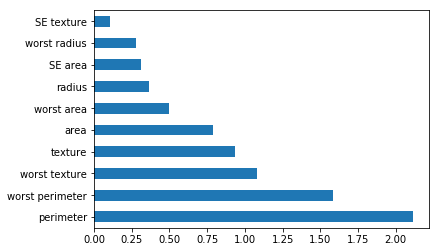

In [5]:
from sklearn.feature_selection import SelectKBest,chi2
import matplotlib.pyplot as plt

bestfeatures_cancer = SelectKBest(score_func=chi2, k=10)
fit_cancer = bestfeatures_cancer.fit(data_cancer_x_scaled, data_cancer_y)

# wyświetlenie uporządkowanego histogramu istotności cech

feat_importances_cancer = pd.Series(fit_cancer.scores_, index=df_cancer_x.columns)
feat_importances_cancer.nlargest(10).plot(kind='barh')
plt.show()

# zapisanie listy najlepszych cech

best_cancer_features = feat_importances_cancer.nlargest(10).index.values

### Wrapper approach
W tym podejściu iteracyjnie dobieramy cechy w oparciu o wydajność klasyfikatora. Zaczynamy z pustym zbiorem cech, w każdej iteracji dodajemy jedną cechę - jeśli dodanie jej zwiększyło wydajność klasyfikatora, to zostaje ona już w naszym podzbiorze. Proces ten powtarzamy do momentu, aż osiągniemy wymaganą liczbę cech. Podejście to jest bardziej kosztowne od <a href="#filterapproach">Filter approach</a>, ponieważ za każdym razem musimy wytrenować model i ocenić jego wydajność. Zdarzają się również przypadki, że dodanie kilku nieco gorszych cech dałoby znacznie lepszy rezultat końcowy niż dodanie jednej najlepszej.

## Selekcja cech z modelu za pomocą Feature Importances
---
Klasyfikatory oparte na drzewach decyzyjnych posiadają atrybut <code>feature_importances_</code>, który opisuje istotność cech wytrenowanego modelu.  
W tym przykładzie wykorzystamy ponownie dane z UCI: <a href="https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29"><b>Breast Cancer Wisconsin (Diagnostic) Data Set</b></a>.


Wykorzystamy klasyfikator <code>ExtraTreesClassifier</code>, <a href="https://pl.wikipedia.org/wiki/Drzewo_decyzyjne#Drzewa_decyzyjne_w_uczeniu_maszynowym">przystępny opis na Wikipedii</a>.

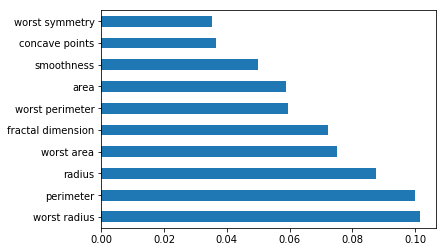

In [6]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

# wytrenowanie modelu

model_cancer = ExtraTreesClassifier()
model_cancer.fit(data_cancer_x_scaled, data_cancer_y)

# selekcja najistotniejszych cech

feat_importances_cancer = pd.Series(model_cancer.feature_importances_, index=df_cancer_x.columns)
feat_importances_cancer.nlargest(10).plot(kind='barh')
plt.show()

# zapisanie listy najlepszych cech

best_cancer_features2 = feat_importances_cancer.nlargest(10).index.values

## Reverse feature selection
---
### <span id="rfe">Rekurencyjna eliminacja cech</span>
W tej metodzie możemy użyć dowolnego estymatora posiadającego atrybut <code>feature_importances_</code>. Celem rekurencyjnej eliminacji cech (RFE) jest selekcja przez rekurencyjne uwzględnienie coraz mniejszych zestawów cech. Najpierw estymator jest szkolony na początkowym zestawie cech, znaczenie każdej z nich uzyskiwane jest przez atrybut <code>feature_importances_</code>. Najmniej znaczące cechy są usuwane z zestawu. Powtarza się to rekurencyjnie, aż pozostanie wymagana liczba cech.  
W tym przykładzie wybierzemy 5 najlepszych cech (dla danych : <a href="https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29"><b>Breast Cancer Wisconsin (Diagnostic) Data Set</b></a>), odrzucając w każdym kroku 5 najgorszych cech.

In [7]:
from sklearn.feature_selection import RFE
rfe_selector = RFE(estimator=ExtraTreesClassifier(), n_features_to_select=5, step=5, verbose=5)
rfe_selector.fit(data_cancer_x_scaled, data_cancer_y)
rfe_support = rfe_selector.get_support()
rfe_feature = df_cancer_x.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')
print(rfe_feature)

Fitting estimator with 30 features.
Fitting estimator with 25 features.
Fitting estimator with 20 features.
Fitting estimator with 15 features.
Fitting estimator with 10 features.
5 selected features
['radius', 'perimeter', 'worst radius', 'worst perimeter', 'worst area']


## Zadanie
---
Wykorzystać dane z UCI, tym razem dotyczące przewidywania rozwodów na podstawie oceny zachowań pomiędzy partnerami w skali od 0 do 4, dataset: <a href="https://archive.ics.uci.edu/ml/datasets/Divorce+Predictors+data+set"><b>Divorce Predictors data set Data Set</b></a>  
<b>Pod podanym linkiem opisane jest znaczenie poszczególnych cech.</b>  
Zbadano 170 przypadków, każdemu mężczyźnie zadano 54 pytania dotyczące jego małżeństwa/żony.  
Class 1 oznacza szczęśliwe małżeństwo, 0 oznacza, że doszło do rozwodu.

In [8]:
# wczytanie danych

df_divorce = pd.read_csv("data/divorce.csv", sep=';')

# podgląd z jakimi danymi mamy do czynienia

df_divorce.head()

,Atr1,Atr2,Atr3,Atr4,Atr5,Atr6,Atr7,Atr8,Atr9,Atr10,...,Atr46,Atr47,Atr48,Atr49,Atr50,Atr51,Atr52,Atr53,Atr54,Class
0,2,2,4,1,0,0,0,0,0,0,...,2,1,3,3,3,2,3,2,1,1
1,4,4,4,4,4,0,0,4,4,4,...,2,2,3,4,4,4,4,2,2,1
2,2,2,2,2,1,3,2,1,1,2,...,3,2,3,1,1,1,2,2,2,1
3,3,2,3,2,3,3,3,3,3,3,...,2,2,3,3,3,3,2,2,2,1
4,2,2,1,1,1,1,0,0,0,0,...,2,1,2,3,2,2,2,1,0,1


In [9]:
# podział na cechy i klasyfikację
df_divorce_x = df_divorce.iloc[:,:54]
df_divorce_y = df_divorce.iloc[:,54]

data_divorce_x = df_divorce_x.to_numpy()
data_divorce_y = df_divorce_y.to_numpy()

# normalizacja danych

from sklearn import preprocessing

scaler_divorce = preprocessing.Normalizer().fit(data_divorce_x)
data_divorce_x_scaled = scaler_divorce.transform(data_divorce_x)

Należy dla tych danych dokonać selekcji najlepszych cech przy pomocy <a href="#filterapproach">Filter approach</a> wykorzystując test <b><i>chi<sup>2</sup></i></b> oraz wykorzystując <a href="#rfe">RFE</a>.

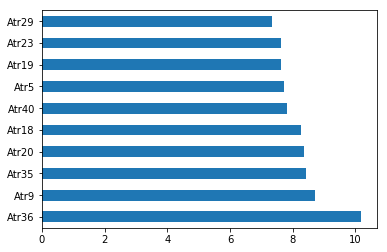

In [10]:
# filter approach

from sklearn.feature_selection import SelectKBest,chi2
import matplotlib.pyplot as plt

bestfeatures_divorce = SelectKBest(score_func=chi2, k=10)
fit_divorce = bestfeatures_divorce.fit(data_divorce_x_scaled, data_divorce_y)

# wyświetlenie uporządkowanego histogramu istotności cech

feat_importances_divorce = pd.Series(fit_divorce.scores_, index=df_divorce_x.columns)
feat_importances_divorce.nlargest(10).plot(kind='barh')
plt.show()

# zapisanie listy najlepszych cech

best_divorce_features = feat_importances_divorce.nlargest(10).index.values

In [12]:
# rfe
from sklearn.feature_selection import RFE
rfe_selector = RFE(estimator=ExtraTreesClassifier(), n_features_to_select=10, step=5, verbose=5)
rfe_selector.fit(data_divorce_x_scaled, data_divorce_y)
rfe_support = rfe_selector.get_support()
rfe_feature = df_divorce_x.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')
print(rfe_feature)

Fitting estimator with 54 features.
Fitting estimator with 49 features.
Fitting estimator with 44 features.
Fitting estimator with 39 features.
Fitting estimator with 34 features.
Fitting estimator with 29 features.
Fitting estimator with 24 features.
Fitting estimator with 19 features.
Fitting estimator with 14 features.
10 selected features
['Atr5', 'Atr9', 'Atr18', 'Atr19', 'Atr20', 'Atr22', 'Atr28', 'Atr29', 'Atr36', 'Atr40']


# 2. Badanie jakości klasyfikatorów k-nn
---
Dokonamy pomiaru jakości klasyfikatorów dla pełnego zestawu N cech, dla mniejszego zestawu m cech wybranych w sposób losowy i dla wyselekcjonowanego zestawu m najlepszych cech. Wykorzystamy do tego celu cechy wybrane za pomocą <a href="#filterapproach">Filter approach</a>, które zapisaliśmy wcześniej jako <code>best_cancer_features</code>.  
k = 1, 3, 5 (sąsiadów),  
m = N, 5, 2 (cech).

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

best_cancer_5 = best_cancer_features[:5]
best_cancer_2 = best_cancer_features[:2]
best_cancer = {
    2: best_cancer_2,
    5: best_cancer_5
}

import random
random_cancer_5 = np.array(random.sample(list(df_cancer_x.columns), 5))
random_cancer_2 = np.array(random.sample(list(df_cancer_x.columns), 2))
random_cancer = {
    2: random_cancer_2,
    5: random_cancer_5
}

# pomiar dla N (wszystkich) cech
for k_neigh in [1, 3, 5]:
    loc_x_train, loc_x_test, loc_y_train, loc_y_test =  train_test_split(df_cancer_x,df_cancer_y, test_size=0.4, random_state=0 )
    neigh = KNeighborsClassifier(n_neighbors=k_neigh, algorithm='auto').fit(loc_x_train, loc_y_train)
    y_pred = neigh.predict(loc_x_test)
    score = accuracy_score(y_true = loc_y_test, y_pred = y_pred)
    print('all \tm = N, k = %d, score = %f' % (k_neigh, score))
    
    
# pomiar m = 2, 5 cech (najlepszych oraz losowych)
for m in [2, 5]:
    loc_x_best_train, loc_x_best_test, loc_y_best_train, loc_y_best_test =  train_test_split(df_cancer_x.loc[:,best_cancer[m]],df_cancer_y, test_size=0.4, random_state=0 )
    loc_x_random_train, loc_x_random_test, loc_y_random_train, loc_y_random_test =  train_test_split(df_cancer_x.loc[:,random_cancer[m]],df_cancer_y, test_size=0.4, random_state=0 )
    for k_neigh in [1, 3, 5]:
        # najlepsze cechy
        neigh = KNeighborsClassifier(n_neighbors=k_neigh, algorithm='auto').fit(loc_x_best_train, loc_y_best_train)
        y_best_pred = neigh.predict(loc_x_best_test)
        best_score = accuracy_score(y_true = loc_y_best_test, y_pred = y_best_pred)
        
        #losowe cechy
        neigh = KNeighborsClassifier(n_neighbors=k_neigh, algorithm='auto').fit(loc_x_random_train, loc_y_random_train)
        y_random_pred = neigh.predict(loc_x_random_test)
        random_score = accuracy_score(y_true = loc_y_random_test, y_pred = y_random_pred)
        
        print('best \tm = %d, k = %d, score = %f' % (m, k_neigh, best_score))
        print('random \tm = %d, k = %d, score = %f' % (m, k_neigh, random_score))


Przykładowa tabelka na wyniki:

<table>
    <tr>
        <th>(best | random)</th>
        <th>k=1</th>
        <th>k=3</th>
        <th>k=5</th>
    </tr>
    <tr>
        <th>m=N</th>
        <td>0.93&nbsp;&nbsp;&nbsp;&nbsp;</td>
        <td>0.94&nbsp;&nbsp;&nbsp;&nbsp;</td>
        <td>0.95&nbsp;&nbsp;&nbsp;&nbsp;</td>
    </tr>
    <tr>
        <th>m=2</th>
        <td>0.94 | 0.74</td>
        <td>0.93 | 0.82</td>
        <td>0.94 | 0.83</td>
    </tr>
    <tr>
        <th>m=5</th>
        <td>0.95 | 0.75</td>
        <td>0.93 | 0.76</td>
        <td>0.93 | 0.75</td>
    </tr>
    </table>

## Zadanie
---
Analogicznie zbadać jakość klasyfikatorów dla danych <a href="https://archive.ics.uci.edu/ml/datasets/Divorce+Predictors+data+set"><b>Divorce Predictors data set Data Set</b></a>, w sprawozdaniu zamieścić wypełnioną tabelkę dla tych danych.

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

best_divorce_5 = best_divorce_features[:5]
best_divorce_2 = best_divorce_features[:2]
best_divorce = {
    2: best_divorce_2,
    5: best_divorce_5
}

import random
random_divorce_5 = np.array(random.sample(list(df_divorce_x.columns), 5))
random_divorce_2 = np.array(random.sample(list(df_divorce_x.columns), 2))
random_divorce = {
    2: random_divorce_2,
    5: random_divorce_5
}

# pomiar dla N (wszystkich) cech
for k_neigh in [1, 3, 5]:
    loc_x_train, loc_x_test, loc_y_train, loc_y_test =  train_test_split(df_divorce_x,df_divorce_y, test_size=0.4, random_state=0 )
    neigh = KNeighborsClassifier(n_neighbors=k_neigh, algorithm='auto').fit(loc_x_train, loc_y_train)
    y_pred = neigh.predict(loc_x_test)
    score = accuracy_score(y_true = loc_y_test, y_pred = y_pred)
    print('all \tm = N, k = %d, score = %f' % (k_neigh, score))
    
    
# pomiar m = 2, 5 cech (najlepszych oraz losowych)
for m in [2, 5]:
    loc_x_best_train, loc_x_best_test, loc_y_best_train, loc_y_best_test =  train_test_split(df_divorce_x.loc[:,best_divorce[m]],df_divorce_y, test_size=0.4, random_state=0 )
    loc_x_random_train, loc_x_random_test, loc_y_random_train, loc_y_random_test =  train_test_split(df_divorce_x.loc[:,random_divorce[m]],df_divorce_y, test_size=0.4, random_state=0 )
    for k_neigh in [1, 3, 5]:
        # najlepsze cechy
        neigh = KNeighborsClassifier(n_neighbors=k_neigh, algorithm='auto').fit(loc_x_best_train, loc_y_best_train)
        y_best_pred = neigh.predict(loc_x_best_test)
        best_score = accuracy_score(y_true = loc_y_best_test, y_pred = y_best_pred)
        
        #losowe cechy
        neigh = KNeighborsClassifier(n_neighbors=k_neigh, algorithm='auto').fit(loc_x_random_train, loc_y_random_train)
        y_random_pred = neigh.predict(loc_x_random_test)
        random_score = accuracy_score(y_true = loc_y_random_test, y_pred = y_random_pred)
        
        print('best \tm = %d, k = %d, score = %f' % (m, k_neigh, best_score))
        print('random \tm = %d, k = %d, score = %f' % (m, k_neigh, random_score))


all 	m = N, k = 1, score = 0.970588
all 	m = N, k = 3, score = 0.970588
all 	m = N, k = 5, score = 0.970588
best 	m = 2, k = 1, score = 0.955882
random 	m = 2, k = 1, score = 0.838235
best 	m = 2, k = 3, score = 0.955882
random 	m = 2, k = 3, score = 0.838235
best 	m = 2, k = 5, score = 0.955882
random 	m = 2, k = 5, score = 0.838235
best 	m = 5, k = 1, score = 0.970588
random 	m = 5, k = 1, score = 0.911765
best 	m = 5, k = 3, score = 0.970588
random 	m = 5, k = 3, score = 0.926471
best 	m = 5, k = 5, score = 0.970588
random 	m = 5, k = 5, score = 0.926471


Wyniki w tabelce:

<table>
    <tr>
        <th>(best | random)</th>
        <th>k=1</th>
        <th>k=3</th>
        <th>k=5</th>
    </tr>
    <tr>
        <th>m=N</th>
        <td>0.97&nbsp;&nbsp;&nbsp;&nbsp;</td>
        <td>0.97&nbsp;&nbsp;&nbsp;&nbsp;</td>
        <td>0.97&nbsp;&nbsp;&nbsp;&nbsp;</td>
    </tr>
    <tr>
        <th>m=2</th>
        <td>0.96 | 0.84</td>
        <td>0.96 | 0.84</td>
        <td>0.96 | 0.84</td>
    </tr>
    <tr>
        <th>m=5</th>
        <td>0.97 | 0.91</td>
        <td>0.97 | 0.93</td>
        <td>0.97 | 0.93</td>
    </tr>
    </table>

In [ ]:
pip install seaborn

# Macierz kowariancji

## Definicje

Elementami macierzy kowariancji są **współczynniki kowariancji** dla par zmiennych losowych opisanych przez parametry wiersza i kolumny macierzy. Macierz ta jest przeniesieniem pojęcia wariancji na przypadek **wielowymiarowy** (jest to macierz wartości oczekiwanych iloczynów wariancji analizowanych dwóch zmiennych).

(Źródło: https://www.statystyka.az.pl/kowariancja-i-korelacja.php)

 “Covariance” indicates the direction of the linear relationship between variables. “Correlation” on the other hand measures both the **strength** and direction of the linear relationship between two variables. Correlation is a function of the covariance.

(Źródło: https://towardsdatascience.com/let-us-understand-the-correlation-matrix-and-covariance-matrix-d42e6b643c22)

Correlation states how the features are related to each other or the target variable (= **modelowana zmienna**).

*Intuicyjnie, jeśli wartość kowariancji jest większa (mniejsza) od 0, to wzrost wartości jednej z cech zwiększa (zmniejsza) wartość zmiennej modelowanej.*

(Źródło: https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e)

## Wyznaczanie macierzy korelacji

Wyznaczymy teraz macierz korelacji, aby później móc narysować **heatmapę**. Skorzystamy ze zbioru z danymi samochodów.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv("https://raw.githubusercontent.com/drazenz/heatmap/master/autos.clean.csv")
X = data.iloc[:,0:20]  #splitting data to independent columns
y = data.iloc[:,-1]    #target column i.e price range
# get correlations of each features in dataset
corr_matrix = data.corr()
corr_matrix

## Heatmap

I narysujemy tzw. **heatmap**:

In [ ]:
corr_features = corr_matrix.index  # e.g. horsepower

plt.figure(figsize=(20,20))
# plot heat map
g=sns.heatmap(data[corr_features].corr(),annot=True,cmap="RdYlGn")

Co można odczytać z heatmapy? Na przykład to, że im większy silnik samochodu, tym wyższa jego cena (engine-sine jest dodatnio skorelowany z price) albo że ilość obrotów na minutę praktycznie nie ma wpływu na cenę samochodu.

# Transformacja PCA

## Definicja

PCA (ang. *Principal Component Analysis*), czyli **analiza głównych składowych** to podstawowa (i prawdopodobnie najczęściej stosowana) technika przetwarzania danych stosowana w celu zredukowania liczby wymiarów i zakresu (aby umożliwić *szybszą* analizę danych). Umożliwia ona podział wielowymiarowych zbiorów danych na zestaw niezależnych komponentów.

## Algorytm

**PCA** identyfikuje kolejne osie zbioru danych o **najwyższej wariancji** (główne składowe). Algorytm transformacji PCA jest następujący: dla obliczonej macierz kowariancji wyznaczamy jej wartości własne i obliczamy wektory własne. Następnie są one normalizowane. Wektor własny o najwyższej wartości własnej jest *pierwszą główną składową*. Kolejne składowe są dobierane po malejących wartościach własnych.


In [ ]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()  # cancer data in dictionary form
cancer.keys()

# dataframe is a two-dimensional, size-mutable, potentially heterogeneous tabular data
df = pd.DataFrame(cancer['data'],columns=cancer['feature_names'])
df.head()  # top values

Mamy dużo cech do zobrazowania. Aby ułatwić sobie zadanie, skorzystamy z PCA.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df)
scaled_data = scaler.transform(df) # scaling data
scaled_data

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)  # instantiate a PCA object
pca.fit(scaled_data)  # find the principal components

In [ ]:
x_pca = pca.transform(scaled_data) # apply dimensionality reduction

Porównajmy teraz wymiary danych przed i po zastosowaniu transformacji PCA:

In [ ]:
print("before PCA: {} vs after PCA: {}".format(scaled_data.shape, x_pca.shape))

Liczba wymiarów *zmalała* do 2. Teraz możemy narysować wykres nowych cech:

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=cancer['target'],cmap='rainbow')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

Nowe cechy są **kombinacjami liniowymi** starych cech i są bardzo zróżnicowane. Zobaczymy to na heatmapie:

In [ ]:
map = pd.DataFrame(pca.components_,columns=cancer['feature_names'])
plt.figure(figsize=(12,6))
sns.heatmap(map, cmap="RdYlGn")

Po lewej stronie obok heatmapy widzimy wartości 0 i 1 które odpowiednio oznaczają nowo powstałe cechy. Na dole widać stare cechy.

(Źródła: https://datascienceplus.com/principal-component-analysis-pca-with-python/ oraz https://pdf.helion.pl/zaaucz/zaaucz.pdf)

Teraz wyświetlimy histogram z 10-ma najlepszymi cechami:

In [ ]:
feature_weights_0 = pca.components_[0]
print(feature_weights_0)

feat_importances_cancer = pd.Series(feature_weights_0, index=cancer['feature_names'])
feat_importances_cancer.nlargest(10).plot(kind='barh')
plt.show()

In [ ]:
feature_weights_1 = pca.components_[1]
print(feature_weights_1)

feat_importances_cancer = pd.Series(feature_weights_1, index=cancer['feature_names'])
feat_importances_cancer.nlargest(10).plot(kind='barh')
plt.show()

Widać, że cechy oraz wagi, z jakimi zostały one wybrane, są zupełnie inne niż w przypadku selekcji cech.

# 5. Badanie jakości klasyfikatorów k-nn - porównanie z PCA
---
Zanim przejdziemy do porównywania jakości klasyfikatorów pokażemy na przykładzie, jak działa transformacja PCA do tego samego wymiaru danych.

In [ ]:
# wczytanie danych

import pandas as pd
import numpy as n
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

df_cancer = pd.read_csv("data/wdbc.data")
# wyodrębnienie cech i klasyfikacji

df_cancer_x = df_cancer.iloc[:,2:]
df_cancer_y = df_cancer.iloc[:,1]
data_cancer_x = df_cancer_x.to_numpy()
data_cancer_y = df_cancer_y.to_numpy()

In [ ]:
from sklearn.model_selection import train_test_split

loc_x_train, loc_x_test, loc_y_train, loc_y_test =  train_test_split(df_cancer_x,df_cancer_y, test_size=0.4, random_state=0 )

scaler_cancer = preprocessing.Normalizer().fit(loc_x_train)
loc_x_train_scaled = scaler_cancer.transform(loc_x_train)
loc_x_test_scaled = scaler_cancer.transform(loc_x_test)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 30)#liczba cech w Winsconsin cancer

pca.fit(loc_x_train_scaled)

pca_x_train = pca.transform(loc_x_train_scaled)
pca_x_test = pca.transform(loc_x_train_scaled)

print(pca_x_train)

In [ ]:
print(loc_x_train_scaled)

In [ ]:
pca_x_train.shape, loc_x_train_scaled.shape

Wnioski z powyższego na podstawie wiedzy jak działa PCA powinno się umieścić w raporcie.

## Porównywanie
---
Teraz przejdziemy do porównywania jakości klasyfikatorów k-nn dla pełnego zestawu cech, oraz wyselekcjowanego zestawu nowych cech. Nowe cechy powstaną poprzez przekształcenie PCA.

In [ ]:
from sklearn.feature_selection import SelectKBest,chi2
import matplotlib.pyplot as plt

scaler_cancer = preprocessing.Normalizer().fit(data_cancer_x)
data_cancer_x_scaled = scaler_cancer.transform(data_cancer_x)

bestfeatures_cancer = SelectKBest(score_func=chi2, k=10)
fit_cancer = bestfeatures_cancer.fit(data_cancer_x_scaled, data_cancer_y)
feat_importances_cancer = pd.Series(fit_cancer.scores_, index=df_cancer_x.columns)

# zapisanie listy najlepszych cech

best_cancer_features = feat_importances_cancer.nlargest(10).index.values

In [134]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


best_cancer_5 = best_cancer_features[:5]
best_cancer_2 = best_cancer_features[:2]
best_cancer = {
    2: best_cancer_2,
    5: best_cancer_5
}

# pomiar dla N (wszystkich) cech
pca = PCA(30)
for k_neigh in [1, 3, 5]:
    loc_x_train, loc_x_test, loc_y_train, loc_y_test =  train_test_split(df_cancer_x,df_cancer_y, test_size=0.4,
                                                                         random_state=0 )
    
    scaler_cancer = preprocessing.Normalizer().fit(loc_x_train)
    loc_x_train_scaled = scaler_cancer.transform(loc_x_train)
    loc_x_test_scaled = scaler_cancer.transform(loc_x_test)
    
    pca.fit(loc_x_train_scaled)
    pca_x_train = pca.transform(loc_x_train_scaled)
    pca_x_test = pca.transform(loc_x_test_scaled)
    
    neigh = KNeighborsClassifier(n_neighbors=k_neigh, algorithm='auto').fit(loc_x_train, loc_y_train)
    neigh_pca = KNeighborsClassifier(n_neighbors=k_neigh, algorithm='auto').fit(pca_x_train, loc_y_train)
    y_pred = neigh.predict(loc_x_test)
    y_pred_pca = neigh.predict(pca_x_test)
    score = accuracy_score(y_true = loc_y_test, y_pred = y_pred)
    pca_score = neigh_pca.score(pca_x_test, loc_y_test)
    
    print('all \tm = N, k = %d, score = %f, pca_score = %f' % (k_neigh, score, pca_score))
    
    
#pomiar m = 2, 5 najlepszych cech
for m in [2, 5]:
    loc_x_best_train, loc_x_best_test, loc_y_best_train, loc_y_best_test =  train_test_split(
        df_cancer_x.loc[:,best_cancer[m]],df_cancer_y, test_size=0.4, random_state=0 )
    
    loc_x_train, loc_x_test, loc_y_train, loc_y_test =  train_test_split(df_cancer_x,df_cancer_y, test_size=0.4,
                                                                         random_state=0 )
    
    pca = PCA(m)
    scaler_cancer = preprocessing.Normalizer().fit(loc_x_train)
    loc_x_best_train_scaled = scaler_cancer.transform(loc_x_train)
    loc_x_best_test_scaled = scaler_cancer.transform(loc_x_test)
    
    pca.fit(loc_x_best_train_scaled)
    pca_x_best_train = pca.transform(loc_x_best_train_scaled)
    pca_x_best_test = pca.transform(loc_x_best_test_scaled)
   
    for k_neigh in [1, 3, 5]:
        neigh = KNeighborsClassifier(n_neighbors=k_neigh, algorithm='auto').fit(loc_x_best_train, loc_y_best_train)
        neigh_pca = KNeighborsClassifier(n_neighbors=k_neigh, algorithm='auto').fit(pca_x_best_train, loc_y_train)
        y_best_pred = neigh.predict(loc_x_best_test)
        y_best_pred_pca = neigh.predict(pca_x_best_test)
        best_score = accuracy_score(y_true = loc_y_best_test, y_pred = y_best_pred)
        pca_best_score = neigh_pca.score(pca_x_best_test, loc_y_best_test)
        
    
        print('best \tm = %d, k = %d, score = %f  pca_score = %f' % (m, k_neigh, best_score, pca_best_score))

all 	m = N, k = 1, score = 0.929825, pca_score = 0.877193
all 	m = N, k = 3, score = 0.938596, pca_score = 0.903509
all 	m = N, k = 5, score = 0.951754, pca_score = 0.934211
best 	m = 2, k = 1, score = 0.938596  pca_score = 0.877193
best 	m = 2, k = 3, score = 0.929825  pca_score = 0.885965
best 	m = 2, k = 5, score = 0.938596  pca_score = 0.899123
best 	m = 5, k = 1, score = 0.947368  pca_score = 0.872807
best 	m = 5, k = 3, score = 0.925439  pca_score = 0.903509
best 	m = 5, k = 5, score = 0.925439  pca_score = 0.929825


Przykładowa tabelka na wyniki (uzupełnioną zamieścić w sprawozdaniu):

<table>
    <tr>
        <th>(old | pca)</th>
        <th>k=1</th>
        <th>k=3</th>
        <th>k=5</th>
    </tr>
    <tr>
        <th>m=N</th>
        <td>0.93 | 0.88</td>
        <td>0.94 | 0.90</td>
        <td>0.95 | 0.93</td>
    </tr>
    <tr>
        <th>m=2</th>
        <td>0.94 | 0.88</td>
        <td>0.93 | 0.89</td>
        <td>0.94 | 0.90</td>
    </tr>
    <tr>
        <th>m=5</th>
        <td>0.95 | 0.87</td>
        <td>0.93 | 0.90</td>
        <td>0.93 | 0.93</td>
    </tr>
    </table>

# 6. Wizualizacja PCA
## Wizualizacja 2D zbioru o N cechach
---

W tym punkcie zajmiemy się jedną z możliwości jaką dostarcza nam PCA - wizualizacją wielowymiarowych zbiorów danych. Kożystając z PCA możemy zmienić rozmiar zbioru cech do 2 lub 3 tym samym umożliwiając przedstawienie rozkładu danych w 2D lub 3D. Teraz zobaczymy jak prezentuje się w 2D zbiór **Breast Cancer Wisconsin**

In [136]:
# wczytanie danych

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA

df_cancer = pd.read_csv("data/wdbc.data")

In [137]:
# wyodrębnienie cech i klasyfikacji

df_cancer_x = df_cancer.iloc[:,2:]
df_cancer_y = df_cancer.iloc[:,1]
data_cancer_x = df_cancer_x.to_numpy()
data_cancer_y = df_cancer_y.to_numpy()

In [138]:
# normalizacja danych

scaler_cancer = preprocessing.Normalizer().fit(data_cancer_x)
data_cancer_x_scaled = scaler_cancer.transform(data_cancer_x)

In [139]:
#teraz przekształcamy nasze wielowymiarowe dane na 2-wymiarowe

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(data_cancer_x_scaled)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

In [140]:
#dodajemy klasyfikacje do komponentów

finalDf = pd.concat([principalDf, pd.DataFrame(data_cancer_y, columns = ['diagnosis'])], axis = 1)

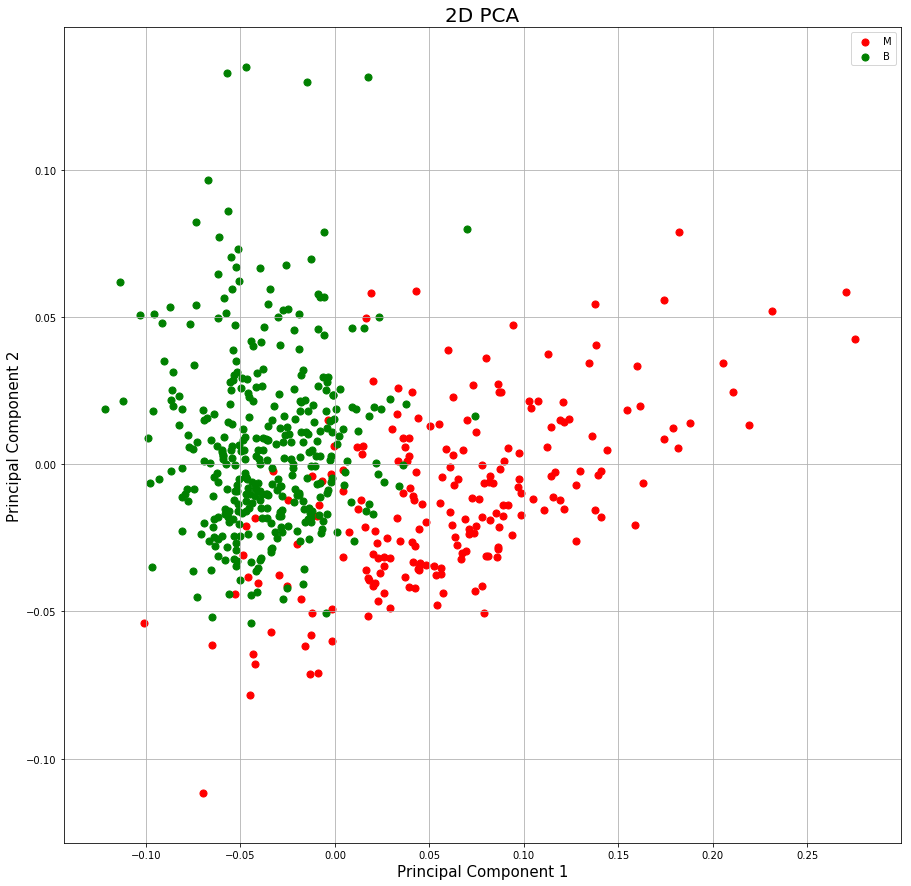

In [141]:
#i w koncu rysujemy wykres

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2D PCA', fontsize = 20)
diagnosis = ['M', 'B']
colors = ['r', 'g']
for diagnose, color in zip(diagnosis,colors):
    indicesToKeep = finalDf['diagnosis'] == diagnose
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(diagnosis)
ax.grid()

Jak widać dane podzieliły się na dwa wyraźne podzbiory - zielony przyadki łagodne i czerwony przypadki złośliwe. Widać jednak że część punktów wyraźnie odstaje od skupiska, a niektóre mieszają się między sobą.

## Szukanie outlierów
---
W tej części zajmiemy się poszukiwaniem danych odstających od reszty, tzw. outlierów oraz przykładów źle sklasyfikowanych, a następnie zaznaczymy je na powyższym wykresie.

Do znajdowania outlierów skorzystamy z metody <a href="https://www.statisticshowto.datasciencecentral.com/probability-and-statistics/z-score/"><b>Z-score</b></a>. Po krótce Z-score przeskalowuje i centralizuje dane, a następnie określa ich odległość od zera. Za outliery uznamy te dane, których wartość bezwzględna z Z-score będzie większa od 3.

In [ ]:
from scipy import stats

z = np.abs(stats.zscore(principalDf))
data_cancer_outliers = principalDf[(z > 3).any(axis = 1)]

Teraz wybierzemy przykłady które zostały źle zakwalifikowane:

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

loc_x_train, loc_x_test, loc_y_train, loc_y_test =  train_test_split(df_cancer_x,df_cancer_y, test_size=0.4,random_state=0 )

scaler_cancer = preprocessing.Normalizer().fit(loc_x_train)
loc_x_train_scaled = scaler_cancer.transform(loc_x_train)
loc_x_test_scaled = scaler_cancer.transform(loc_x_test)

pca = PCA(2)
pca.fit(loc_x_train_scaled)
pca_x_train = pca.transform(loc_x_train_scaled)
pca_x_test = pca.transform(loc_x_test_scaled)

neigh_pca = KNeighborsClassifier(n_neighbors=5, algorithm='auto').fit(pca_x_train, loc_y_train)
y_pred_pca = neigh_pca.predict(pca_x_test)

labels = loc_y_test.to_numpy()

pca_x_test_df = pd.DataFrame(pca_x_test, columns = ['principal component 1', 'principal component 2'])
pca_x_test_df = pca_x_test_df.set_index(loc_y_test.index)
pca_x_test_df


incorrects = pca_x_test_df[y_pred_pca != loc_y_test]

Teraz możemy stworzyć wykres:

In [ ]:
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2D Visualisatin', fontsize = 20)
diagnosis = ['M', 'B']
colors = ['r', 'g']
legend = ['M', 'B', 'Outliers', 'Incorrects']
for diagnose, color in zip(diagnosis,colors):
    indicesToKeep = finalDf['diagnosis'] == diagnose
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.scatter(data_cancer_outliers['principal component 1']
              ,data_cancer_outliers['principal component 2']
              , c = 'm'
              , s = 50)
ax.scatter(incorrects['principal component 1']
              ,incorrects['principal component 2']
              , c = 'k'
              , s = 50)
ax.legend(legend)
ax.grid()

# 7. Zadanie
---
W zbiorach MNIST, NMIST, CIFAR-10 (wybrać tyle zbiorów, ile osób robi sprawozdanie). Do dalszych eksperymentów wybrać ilość przykładów nie większy niż M=2xN !!!(N- ilość cech):

a.	 znaleźć NAJMNIEJ INFORMATYWNE cechy (piksele). Zobrazować je na rysunku, wielkością odpowiadającemu klasyfikowanym obrazkom.  
b.	Dokonać klasyfikacji k-nn na pełnym zbiorze i zbiorze bez m najmniej informatywnych cech.  
c.	Przetransformować zbiory przy pomocy PCA z N-D do N-D. Jak wyglądają (obrazki) wektory własne odpowiadające największym wartością własnym. Sprawdzić, czy poprawił się wynik klasyfikacji. Dokonać wizualizacji 2-D przy pomocy PCA.  
d.	Usunąć m najmniej informatywnych cech PCA. Jak wygląda wynik klasyfikacji.  
e.	Wybrac m NAJLEPSZYCH cech PCA. Jak wygląda teraz wynik klasyfikacji.  
f.	Wartość m w przypadku wyboru najgorszych cech ma być duże (dla N=784 jakieś m=500), w przypadku wyboru najlepszych małe (m=10-20)  
g.	Dokonać klasyfikacji z PCA i bez PCA (na pełnym zbiorze cech i zadanym małym M), ale zwiększając ilość przykładów przy pomocy augmentacji (imgaug).  
h.	Wnioski (co lepsze augmentacja czy inżynieria cech?)  


## a)

In [23]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

(x_mnist, y_mnist), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

n_features = x_mnist.shape[1] * x_mnist.shape[2]
n_samples = 2 * n_features


x_sub, y_sub = resample(x_mnist, y_mnist, n_samples=n_samples, replace=False, random_state=0)
x_sub = x_sub.reshape(-1, n_features)


In [39]:
n_best_features = 1*n_features//2

from sklearn.feature_selection import RFE
rfe_selector = RFE(estimator=ExtraTreesClassifier(), n_features_to_select=n_best_features, step=50, verbose=5)
rfe_selector.fit(x_sub, y_sub)
rfe_support = rfe_selector.get_support()
worst_support = np.copy(rfe_support)
for i in range(rfe_support.shape[0]):
    worst_support[i] = not rfe_support[i]
rfe_support = rfe_support.reshape(28,28)
worst_support = worst_support.reshape(28,28)


Fitting estimator with 784 features.
Fitting estimator with 734 features.
Fitting estimator with 684 features.
Fitting estimator with 634 features.
Fitting estimator with 584 features.
Fitting estimator with 534 features.
Fitting estimator with 484 features.
Fitting estimator with 434 features.


True

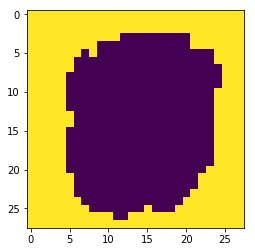

In [41]:
import matplotlib.pyplot as plt
plt.imshow(worst_support)
#rfe_support

## b)

In [79]:
x_train, x_test, y_train, y_test = train_test_split(x_sub, y_sub, test_size=0.4, random_state=0)

In [80]:
model = KNeighborsClassifier(n_neighbors=5, algorithm='auto')
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
all_score = accuracy_score(y_true = y_test, y_pred = y_pred)
all_score

0.8789808917197452

In [65]:
x_train.shape

(940, 784)

In [81]:
x_train_best = x_train[:,rfe_support.reshape(-1)]
x_test_best = x_test[:,rfe_support.reshape(-1)]

model = KNeighborsClassifier(n_neighbors=5, algorithm='auto')
model.fit(x_train_best, y_train)

y_pred = model.predict(x_test_best)
all_score = accuracy_score(y_true = y_test, y_pred = y_pred)
all_score

0.8869426751592356

# c)

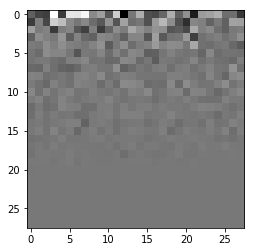

In [133]:
from sklearn import preprocessing
from sklearn.decomposition import PCA

scaler = preprocessing.Normalizer().fit(x_train)
x_train_scaled = scaler_cancer.transform(x_train)
x_test_scaled = scaler_cancer.transform(x_test)

pca = PCA(784)
pca.fit(x_train_scaled)
pca_x_train = pca.transform(x_train_scaled)
pca_x_test = pca.transform(x_test_scaled)

plt.imshow(pca_x_test[100].reshape(28,28),cmap='gray')

In [99]:
neigh_pca = KNeighborsClassifier(n_neighbors=5, algorithm='auto').fit(pca_x_train, y_train)
y_pred_pca = neigh_pca.predict(pca_x_test)

pca_score = neigh_pca.score(pca_x_test, y_test)
pca_score

0.8996815286624203

In [120]:
pca = PCA(2)

scaler = preprocessing.Normalizer().fit(x_sub)
x_scaled = scaler_cancer.transform(x_sub)

pca.fit(x_scaled)
principalComponents = pca.fit_transform(x_scaled)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, pd.DataFrame(y_sub, columns = ['labels'])], axis = 1)

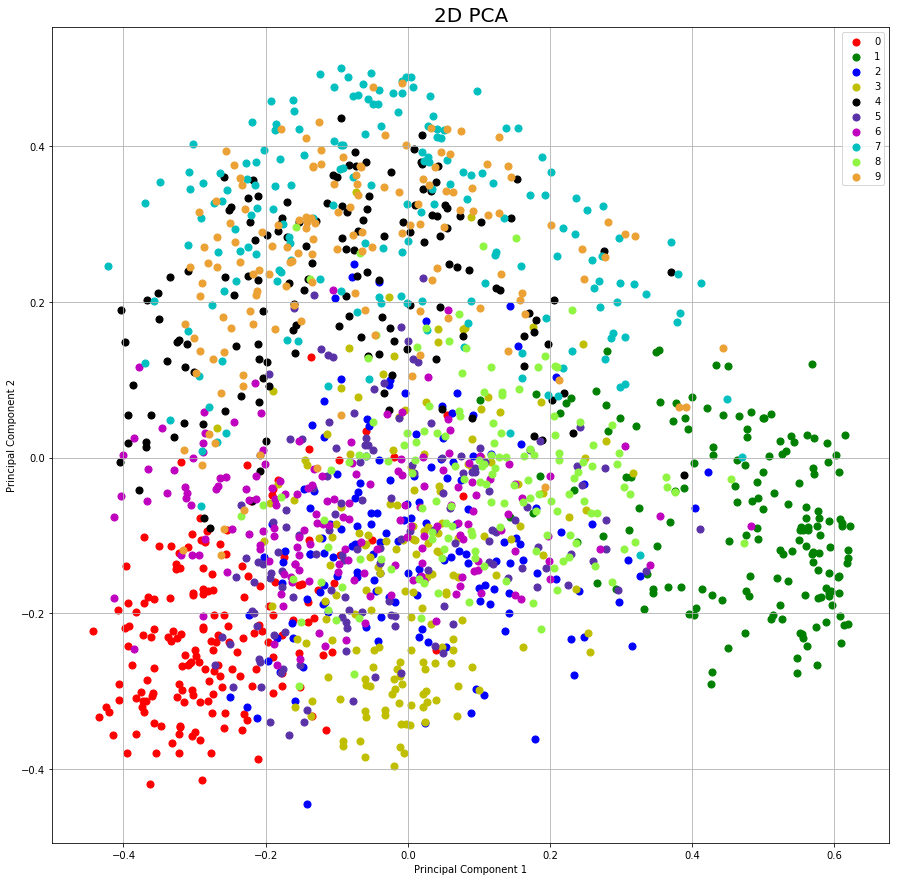

In [126]:
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 10)
ax.set_ylabel('Principal Component 2', fontsize = 10)
ax.set_title('2D PCA', fontsize = 20)
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
colors = ['r', 'g', 'b', 'y', 'k', '#5a32a8', 'm', 'c', '#90f542', '#eba134']
for label, color in zip(labels,colors):
    indicesToKeep = finalDf['labels'] == label
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(labels)
ax.grid()